# 0. Imports

In [1]:
import os

import pandas as pd
import torch ## torch let's us create tensors and also provides helper functions
import torch.nn as nn ## torch.nn gives us nn.Module(), nn.Embedding() and nn.Linear()
import torch.nn.functional as F # This gives us the softmax() and argmax()
from torch.optim import Adam ## We will use the Adam optimizer, which is, essentially, 
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device =torch.device("cpu")
print(f"Dispositivo disponível: {device}")

import warnings
# Ignora todos os warnings do tipo DeprecationWarning
warnings.filterwarnings("ignore")

Dispositivo disponível: cuda


In [2]:
# Define a function to pad sequences to a specified length
def pad_sequences(sequences, max_len, pad_token):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_len:
            seq.extend([pad_token] * (max_len - len(seq)))
        padded_sequences.append(seq)
    return padded_sequences

# 1. Dataset

In [3]:
# Get current working directory
current_directory = os.getcwd()

df = pd.read_excel(current_directory+"\Porto_Database.xlsx").drop(columns=["Unnamed: 0","Fonte"],axis=1)[:10]

df["Final"] = df["Final"].apply(lambda x: x+" <EOS>")

df.head()

,Final
0,The Porto Tram Museum (Museu do Carro Eléctric...
1,The rabelo boat is a traditional Portuguese wo...
2,STCP (Sociedade de Transportes Colectivos do P...
3,The tram system of Porto in Portugal is operat...
4,"The FC Porto Museum, officially known as FC Po..."


# 2. Tokenizer

## 2.1. Data to Tokenize

In [8]:
df_token = pd.read_excel(current_directory+"\Porto_Database.xlsx").drop(columns=["Unnamed: 0","Fonte"],axis=1)

df_token = '\n'.join(df_token.astype(str).apply(lambda x: ' '.join(x), axis=1))


In [70]:
tokens = df_token.split()
unique_tokens = set([token.lower() for token in tokens])
tokens_to_id = {token: idx for idx, token in enumerate(unique_tokens)}
tokens_to_id['<PAD>'] = len(tokens_to_id)
tokens_to_id['<EOS>'] = len(tokens_to_id)

id_to_token = dict(map(reversed, tokens_to_id.items()))


In [72]:
# Initialize lists for inputs and outputs
inputs = []
labels = []

for t in range(df.shape[0]):
        inputs.append(df.iloc[t][0].split()[:-1])
        # print(t.split()[i:-1])
        labels.append(df.iloc[t][0].split()[1:])


final_inputs = []
final_labels = []

# Process each line to split into input and output
for inp, out in zip(inputs, labels):        
        tokenized_input = [ tokens_to_id[token.lower()] if token != '<EOS>' else tokens_to_id[token] for token in inp]
        final_inputs.append(tokenized_input)
        tokenized_labels = [tokens_to_id[token.lower()] if token != '<EOS>' else tokens_to_id[token] for token in out]
        final_labels.append(tokenized_labels)

padded_inputs = pad_sequences(final_inputs, 700, tokens_to_id['<PAD>'])
padded_labels = pad_sequences(final_labels, 700, tokens_to_id['<PAD>'])

# Convert to tensors
inputs = torch.tensor(final_inputs, dtype=torch.int64)
labels = torch.tensor(final_labels, dtype=torch.int64)

# 3. Batch

In [74]:
max_len=3000 #input
vocab_size = len(tokens_to_id)
d_model=2000
max_length = 20 #output

# 4. DataLoader - Prepare Dataset for Training

In [75]:
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

# 5. Embeddings

## 5.1. Class

In [76]:
class Embeddings(nn.Module):
    def __init__(self,vocab_size=vocab_size, d_model=d_model):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        embeddings = self.embeddings(x)
        return embeddings

## 5.2. Test Class

In [77]:
embeddings = Embeddings()
emb = embeddings(inputs[0])
emb

tensor([[-0.1687,  0.0578, -2.4049,  ..., -1.6830, -0.3965, -1.4982],
        [-0.7585,  0.1634, -0.4372,  ..., -0.6189, -2.2595,  0.9568],
        [ 1.3349, -0.4553,  0.4002,  ..., -0.8354, -1.6148, -0.5991],
        ...,
        [ 0.0032,  1.0589,  0.2159,  ...,  1.3845, -1.4323,  0.1933],
        [ 0.0032,  1.0589,  0.2159,  ...,  1.3845, -1.4323,  0.1933],
        [ 0.0032,  1.0589,  0.2159,  ...,  1.3845, -1.4323,  0.1933]],
       grad_fn=<EmbeddingBackward0>)

# 6. Positional Encodings

## 6.1. Class

In [78]:
class PositionEncoding(nn.Module):
    
    def __init__(self, d_model=d_model, max_len=max_len):        
        super().__init__()
       
        pe = torch.zeros(max_len, d_model)  
        position = torch.arange(start=0, end=max_len, step=1).float().unsqueeze(1)

        embedding_index = torch.arange(start=0, end=d_model, step=2).float()
        
        div_term = 1/torch.tensor(10000.0)**(embedding_index / d_model)
        
        pe[:, 0::2] = torch.sin(position * div_term) ## every other column, starting with the 1st, has sin() values
        pe[:, 1::2] = torch.cos(position * div_term) ## every other column, starting with the 2nd, has cos() values
      
        ## Now we "register 'pe'.
        self.register_buffer('pe', pe) ## "register_buffer()" ensures that
                                       ## 'pe' will be moved to wherever the model gets
                                       ## moved to. So if the model is moved to a GPU, then,
                                       ## even though we don't need to optimize 'pe', it will 
                                       ## also be moved to that GPU. This, in turn, means
                                       ## that accessing 'pe' will be relatively fast copared
                                       ## to having a GPU have to get the data from a CPU.

    def forward(self, word_embeddings):
        # print(word_embeddings.size())
        # print(self.pe[:word_embeddings.size(0), :].size())#[:word_embeddings.size(0), :])
        return word_embeddings.to(device) + self.pe[:word_embeddings.size(0), :].to(device) ## word_embeddings.size(0) = number of embeddings
                                                                      ## NOTE: That second ':' is optional and 
                                                                      ## we could re-write it like this: 
                                                                      ## self.pe[:word_embeddings.size(0)]

## 6.2. Test Class

In [79]:
PE = PositionEncoding()
pe_embeddings = PE(emb)
pe_embeddings

tensor([[-0.1687,  1.0578, -2.4049,  ..., -0.6830, -0.3965, -0.4982],
        [ 0.0829,  0.7037,  0.3993,  ...,  0.3811, -2.2594,  1.9568],
        [ 2.2442, -0.8715,  1.3170,  ...,  0.1646, -1.6146,  0.4009],
        ...,
        [-0.4169,  1.9664, -0.2986,  ...,  2.3820, -1.3620,  1.1908],
        [ 0.5398,  1.9027,  0.6511,  ...,  2.3820, -1.3619,  1.1908],
        [ 1.0032,  1.0633,  1.2075,  ...,  2.3820, -1.3618,  1.1908]],
       device='cuda:0', grad_fn=<AddBackward0>)

# 7. Self-Attention

## 7.1. Class

In [80]:
class Attention(nn.Module): 
    
    def __init__(self, d_model=d_model):     
        super().__init__()
        
        self.d_model=d_model
        self.W_q = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_k = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_v = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        
        self.row_dim = 0
        self.col_dim = 1

        
    def forward(self, pos_embeddings_q, pos_embeddings_k, pos_embeddings_v, mask=None):
        
        q = self.W_q(pos_embeddings_q)
        k = self.W_k(pos_embeddings_k)
        v = self.W_v(pos_embeddings_v)
        
        sims = torch.matmul(q, k.transpose(dim0=self.row_dim, dim1=self.col_dim))

        scaled_sims = sims / torch.tensor(k.size(self.col_dim)**0.5).to(device)

        if mask is not None:
            scaled_sims = scaled_sims.masked_fill(mask=mask.to(device), value=-1e9) 
        
        attention_percents = F.softmax(scaled_sims, dim=self.col_dim)

        # Scale the values by their associated percentages and add them up.
        attention_scores = torch.matmul(attention_percents, v)
        
        return attention_scores.to(device)

## 7.2. Test Class

In [81]:
attention = Attention().to(device)
attention(pe_embeddings,pe_embeddings,pe_embeddings)

tensor([[-0.3720, -0.2626,  0.0891,  ..., -0.0006, -0.0307, -0.0598],
        [-0.3140, -0.2253,  0.0756,  ...,  0.0193,  0.0069,  0.0032],
        [-0.3532, -0.2602,  0.1212,  ..., -0.0248, -0.0509, -0.0494],
        ...,
        [-0.3403, -0.2430,  0.0784,  ..., -0.0147, -0.0133, -0.0013],
        [-0.3459, -0.2474,  0.0873,  ..., -0.0169, -0.0146, -0.0101],
        [-0.3500, -0.2486,  0.0908,  ..., -0.0246, -0.0166, -0.0170]],
       device='cuda:0', grad_fn=<MmBackward0>)

# 8. DecoderOnlyTransformer

## 8.1 Class

In [82]:
torch.manual_seed(0)

class DecoderOnlyTransformer(nn.Module):
    
    def __init__(self, vocab_size=vocab_size, d_model=d_model, max_len=max_len):
        
        super().__init__()
        
        self.we = Embeddings(vocab_size, d_model)     
        
        self.pe = PositionEncoding(d_model=d_model, 
                                   max_len=max_len)

        self.self_attention = Attention(d_model=d_model)

        self.fc_layer = nn.Linear(in_features=d_model, out_features=vocab_size)
        
        self.loss = nn.CrossEntropyLoss()
        
        
    def forward(self, token_ids):
                
        word_embeddings = self.we(token_ids)     
        pe_embeddings = self.pe(word_embeddings)
        
        mask = torch.tril(torch.ones((token_ids.size(dim=0), token_ids.size(dim=0))))#, device=self.device))
        mask = mask == 0
        
        self_attention_values = self.self_attention(pe_embeddings, 
                                                    pe_embeddings, 
                                                    pe_embeddings, 
                                                    mask=mask)
        
        residual_connection_values = pe_embeddings + self_attention_values
        
        fc_layer_output = self.fc_layer(residual_connection_values)
        
        return fc_layer_output


## 8.2. Test Class

In [83]:
model = DecoderOnlyTransformer(vocab_size=len(tokens_to_id), d_model=d_model, max_len=max_len).to(device)
## Now create the input for the transformer...
model_input = torch.tensor([tokens_to_id["where"],
                            tokens_to_id["is"], 
                            tokens_to_id["porto"]]).to(device)

input_length = model_input.size(dim=0)

## Now get get predictions from the model
predictions = model(model_input) 
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])

predicted_ids = predicted_id


for i in range(input_length, max_length):
    if (predicted_id == tokens_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break
    
    model_input = torch.cat((model_input, predicted_id.to(device)))
    
    predictions = model(model_input) 
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))
        
## Now printout the predicted output phrase.
answer = []
for id in predicted_ids: 
    answer.append(id_to_token[id.item()])

" ".join(answer)

'zaravinas 934, 7.1 upscale -ribeira, (praia artefactos fisico 115.74 english/irish, https://www.tripadvisor.com/restaurant_review-g1066093-d27197494-reviews-3_netinhas-maia_porto_district_northern_portugal.html. chocolates scarlatti, damned https://www.booking.com/hotel/pt/porto-spot-hostel.en-gb.html?selected_currency=usd&lang=en-gb&group_adults=2&group_children=0&no_rooms=1 https://www.editoryhotels.com/boulevard-aliados-porto/restaurantes/restaurante-ilicito/. minted 19:00.'

# 9. Treino

## 9.1. Batch - Treino

In [85]:
model = DecoderOnlyTransformer(vocab_size=len(tokens_to_id), d_model=d_model, max_len=max_len).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=tokens_to_id['<PAD>'])
optimizer = Adam(model.parameters(), lr=0.0001)

## 9.2. Loop

Epoch 1/300, Loss: 9.64799022674560546875
Epoch 2/300, Loss: 7.90225076675415039062
Epoch 3/300, Loss: 6.86414766311645507812
Epoch 4/300, Loss: 6.21644353866577148438
Epoch 5/300, Loss: 5.63541507720947265625
Epoch 6/300, Loss: 5.26998472213745117188
Epoch 7/300, Loss: 4.85587930679321289062
Epoch 8/300, Loss: 4.46452999114990234375
Epoch 9/300, Loss: 4.15973758697509765625
Epoch 10/300, Loss: 3.79403567314147949219
Epoch 11/300, Loss: 3.56083726882934570312
Epoch 12/300, Loss: 3.28416228294372558594
Epoch 13/300, Loss: 2.92825651168823242188
Epoch 14/300, Loss: 2.72146892547607421875
Epoch 15/300, Loss: 2.56595826148986816406
Epoch 16/300, Loss: 2.39306902885437011719
Epoch 17/300, Loss: 2.18351864814758300781
Epoch 18/300, Loss: 2.04192209243774414062
Epoch 19/300, Loss: 1.88763523101806640625
Epoch 20/300, Loss: 1.78786265850067138672
Epoch 21/300, Loss: 1.73966681957244873047
Epoch 22/300, Loss: 1.76297211647033691406
Epoch 23/300, Loss: 1.60599827766418457031
Epoch 24/300, Loss: 

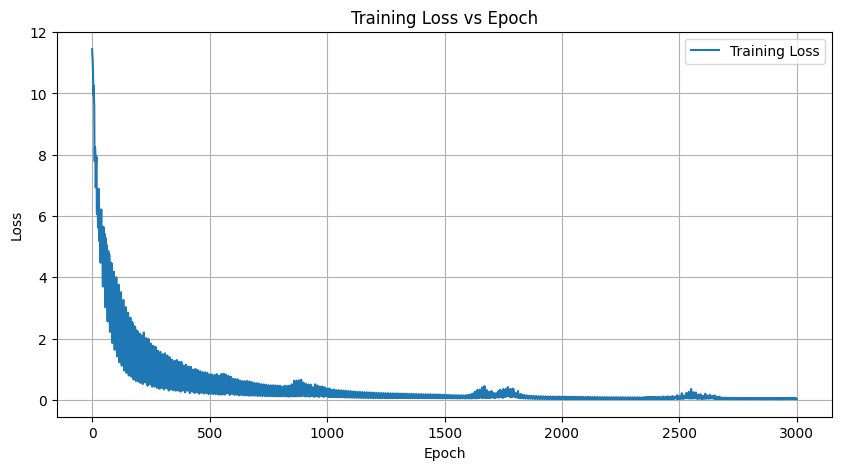

In [86]:
losses=[]
## Train the model
num_epochs = 300

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in dataloader:
        inputs, labels = batch
        # print(inputs)
        # print(inputs.squeeze(0))
        ## Forward pass
        outputs = model(inputs.squeeze(0).to(device))
        # print(inputs.squeeze(0).size(),outputs.size(),labels.view(-1).size())
        # print(inputs.squeeze(0))
        # print(labels.view(-1))
        # print(outputs)
        
        ## Compute the loss
        loss = loss_fn(outputs.to(device), labels.view(-1).to(device))
        
        ## Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.to("cpu").detach().numpy())

    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss/len(inputs):.20f}')
    elif loss<0.00000000001:
        break


plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [112]:
# The Porto Tram Museum (Museu do Carro Eléctrico) is a museum operated by the Sociedade de Transportes Colectivos do Porto
# "The rabelo boat is a traditional Portuguese wooden cargo boat that was used for centuries to transport people and goods along the Douro River.  It is flat-bottomed, with a shallow draught, 
prompt = "The Porto Tram Museum (museu do carro eléctrico) is a museum operated"
prompt_listed = list(prompt.split())
for p in prompt_listed:
    prompt_tokenized = torch.tensor([tokens_to_id[token.lower()] for token in prompt_listed])


## Now get get predictions from the model
predictions = model(prompt_tokenized.to(device)) 
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id
max_length=250
for i in range(max_length):

    if (predicted_id == tokens_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break
    
    prompt_tokenized = torch.cat((prompt_tokenized, predicted_id))
    
    predictions = model(prompt_tokenized.to(device)) 
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))
        
## Now printout the predicted output phrase.
answer = []
for id in predicted_ids: 
    answer.append(id_to_token[id.item()])

# The rabelo boat is a traditional Portuguese wooden cargo boat that was used for centuries to transport people and goods along the Douro River.  It is flat-bottomed, with a shallow draught, which was necessary to navigate the often shallow fast-flowing waters of the upper Douro prior to the construction of dams and locks from 1968 onwards.
print("Training Set: "+ "The Porto Tram Museum (Museu do Carro Eléctrico) is a museum operated by the Sociedade de Transportes Colectivos do Porto. It was inaugurated in 1992 and is installed \nin a former thermoelectric power station next to the River Douro in Massarelos, Porto, Portugal. It exhibits material related to the history of trams in Porto.")
print("--------------------")
print("Prompt: "+prompt)
print("--------------------")
print("Cahtbot Answer: "+" ".join(answer))

Training Set: The Porto Tram Museum (Museu do Carro Eléctrico) is a museum operated by the Sociedade de Transportes Colectivos do Porto. It was inaugurated in 1992 and is installed 
in a former thermoelectric power station next to the River Douro in Massarelos, Porto, Portugal. It exhibits material related to the history of trams in Porto.
--------------------
Prompt: The Porto Tram Museum (museu do carro eléctrico) is a museum operated
--------------------
Cahtbot Answer: by the sociedade de transportes colectivos do porto. it was inaugurated in 1992 and is installed in a former thermoelectric power station next to the river douro in massarelos, porto, portugal. it exhibits material related to the history of trams in porto. the collection contains 16 electric cars, 5 trailers, and two maintenance vehicles as well as a former equipment of the power plant, which provided electricity for the tram lines. == the building == the construction of the building as a power plant was completed in

# 10. Save the Model

In [100]:
model_path = "simple_model.pth"

In [101]:

torch.save(model.state_dict(), model_path)

# Para também salvar o otimizador e outras informações
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}
torch.save(checkpoint, "simple_model_checkpoint.pth")

# 11. Load the Model

In [102]:
# Carregando o modelo
loaded_model = DecoderOnlyTransformer().to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()  # Coloca o modelo em modo de avaliação

# Para carregar o checkpoint completo
checkpoint = torch.load("simple_model_checkpoint.pth")
loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Confirme que os estados foram carregados corretamente
print(loaded_model)
print(optimizer)
print(f"Start epoch: {start_epoch}")
print(f"Loss: {loss}")

DecoderOnlyTransformer(
  (we): Embeddings(
    (embeddings): Embedding(74732, 2000)
  )
  (pe): PositionEncoding()
  (self_attention): Attention(
    (W_q): Linear(in_features=2000, out_features=2000, bias=False)
    (W_k): Linear(in_features=2000, out_features=2000, bias=False)
    (W_v): Linear(in_features=2000, out_features=2000, bias=False)
  )
  (fc_layer): Linear(in_features=2000, out_features=74732, bias=True)
  (loss): CrossEntropyLoss()
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Start epoch: 299
Loss: 0.02428101748228073


## 11.1. Test Loaded Model

In [5]:
prompt = "The Porto Tram Museum (museu do carro eléctrico) is a museum operated"
prompt_listed = list(prompt.split())
for p in prompt_listed:
    prompt_tokenized = torch.tensor([tokens_to_id[token.lower()] for token in prompt_listed])


## Now get get predictions from the model
predictions = loaded_model(prompt_tokenized.to(device))
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id
max_length=1000
for i in range(max_length):

    if (predicted_id == tokens_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break
    
    prompt_tokenized = torch.cat((prompt_tokenized, predicted_id))
    
    predictions = loaded_model(prompt_tokenized.to(device)) 
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))
        
## Now printout the predicted output phrase.
answer = []
for id in predicted_ids: 
    answer.append(id_to_token[id.item()])

# The rabelo boat is a traditional Portuguese wooden cargo boat that was used for centuries to transport people and goods along the Douro River.  It is flat-bottomed, with a shallow draught, which was necessary to navigate the often shallow fast-flowing waters of the upper Douro prior to the construction of dams and locks from 1968 onwards.
print("The Porto Tram Museum (Museu do Carro Eléctrico) is a museum operated by the Sociedade de Transportes Colectivos do Porto. It was inaugurated in 1992 and is installed \nin a former thermoelectric power station next to the River Douro in Massarelos, Porto, Portugal. It exhibits material related to the history of trams in Porto.")
print(prompt)
" ".join(answer)